In [1]:
import os

kaggle_dir = '/root/.kaggle'
os.makedirs(kaggle_dir, exist_ok=True)
print(f"Created directory: {kaggle_dir}")

Created directory: /root/.kaggle


In [2]:
import json

kaggle_creds = {
    'username': 'manasapanuganti2303',
    'key': 'b3f1dbff3c1723fb6439dddea361c4e5'
}

kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')
with open(kaggle_json_path, 'w') as f:
    json.dump(kaggle_creds, f)

os.chmod(kaggle_json_path, 0o600)
print(f"Kaggle API key saved to: {kaggle_json_path}")

Kaggle API key saved to: /root/.kaggle/kaggle.json


In [3]:
!ls


'archive (1) (1).zip'   sample_data


In [4]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to your file (change to match your folder)
file_path = '/content/archive (1) (1).zip'

# Read CSV
df = pd.read_csv(file_path)

print("✅ File loaded successfully from Google Drive!")
print(df.head())

Mounted at /content/drive
✅ File loaded successfully from Google Drive!
   Unnamed: 0          id publishedAt  \
0           0  3800928381  2024-01-09   
1           1  3800929078  2024-01-09   
2           2  3792399495  2023-12-27   
3           3  3792604197  2023-12-27   
4           4  3808399427  2024-01-23   

                                               title  \
0   Front-end Engineer/Web Developer (SDE 1 &amp; 2)   
1  Android Developer-SDE 1 &amp; 2(Software Devel...   
2                                      Web Developer   
3                                      Web Developer   
4                                  Software Engineer   

                         companyName   postedTime  applicationsCount  \
0                               BOX8  3 weeks ago               85.0   
1                               BOX8  3 weeks ago               80.0   
2  Mahe Technologies Private Limited  1 month ago               75.0   
3  Mahe Technologies Private Limited  1 month ago       

In [5]:
import os
import re
import sqlite3
from concurrent.futures import ThreadPoolExecutor
from collections import Counter
import pandas as pd

# ------------------------
# CONFIG
# ------------------------
DB_PATH = "skills.db"
JOB_CSV_PATH = "/content/archive (1) (1).zip"
OUTPUT_CSV = "cleaned_job_skills_output_db.csv"
MAX_WORKERS = 8

# ------------------------
# AUTO-FIX: ENSURE TABLE EXISTS
# ------------------------
DEFAULT_SKILLS = [
    'Python','Java','SQL','JavaScript','React','Django','Spring','Docker','Kubernetes',
    'AWS','Azure','GCP','Pandas','NumPy','TensorFlow','PyTorch','scikit-learn','HTML','CSS',
    'Flask','Excel','Power BI','Node.js','TypeScript','PostgreSQL','MySQL','Redis','Kafka',
    'Machine Learning','Data Science'
]

def ensure_skills_table():
    """Ensures the DB exists, table exists, and default skills are inserted."""
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()

    # Create table if missing
    cur.execute("""
        CREATE TABLE IF NOT EXISTS skills (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT UNIQUE NOT NULL,
            normalized TEXT
        );
    """)

    # Insert default skills
    for s in DEFAULT_SKILLS:
        cur.execute(
            "INSERT OR IGNORE INTO skills (name, normalized) VALUES (?, ?);",
            (s, s.lower())
        )

    conn.commit()
    conn.close()

# ------------------------
# LOAD SKILLS
# ------------------------
def load_skills_from_db():
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()
    cur.execute("SELECT name FROM skills ORDER BY name COLLATE NOCASE;")
    rows = cur.fetchall()
    conn.close()
    return [r[0] for r in rows]

# ------------------------
# TEXT CLEANING
# ------------------------
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# ------------------------
# BUILD REGEX
# ------------------------
# skills == ["node", "python"]
def build_skill_pattern(skills):
    if not skills:
        return None

    skills_sorted = sorted(skills, key=lambda s: len(s), reverse=True)
    escaped = [re.escape(s) for s in skills_sorted]
    regex = r'\b(' + '|'.join(escaped) + r')\b'

    return re.compile(regex, flags=re.IGNORECASE)

# ------------------------
# SKILL EXTRACTION
# ------------------------
def extract_skills_from_text(text, pattern):
    if not text or pattern is None:
        return []
    found = pattern.findall(text)
    found_norm = [f.lower() for f in found]

    seen = []
    for s in found_norm:
        if s not in seen:
            seen.append(s)

    return seen

# ------------------------
# MAIN PIPELINE
# ------------------------
def main():

    ensure_skills_table()
    print("Skills table ready.\n")
    skills = load_skills_from_db()


    skill_pattern = build_skill_pattern(skills)
    if skill_pattern is None:
        print("ERROR: No skills found in DB.")
        return

    if not os.path.exists(JOB_CSV_PATH):
        raise FileNotFoundError(f"Job file not found: {JOB_CSV_PATH}")

    df = pd.read_csv(JOB_CSV_PATH)

    if "description" not in df.columns:
        possible = [c for c in df.columns if "description" in c.lower()]
        if not possible:
            raise ValueError("No description column found.")
        df["description"] = df[possible[0]].astype(str)

    df["clean_description"] = df["description"].apply(clean_text)

    def worker(text):
        return extract_skills_from_text(text, skill_pattern)

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as exe:
        df["skills_found"] = list(exe.map(worker, df["clean_description"]))


    counts = Counter()
    for row in df["skills_found"]:
        for s in row:
            counts[s] += 1

    counts_df = pd.DataFrame(counts.most_common(), columns=["skill", "count"])
    counts_df.to_csv("skill_counts_from_db.csv", index=False)

    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved: {OUTPUT_CSV}")
    print("\nTop skills:")
    print(counts_df.head(10).to_string(index=False))


if __name__ == "__main__":
    main()


Skills table ready.

Saved: cleaned_job_skills_output_db.csv

Top skills:
           skill  count
          python    144
           excel    120
machine learning    104
             sql     97
    data science     76
             aws     59
            java     56
      javascript     53
           azure     51
             css     37


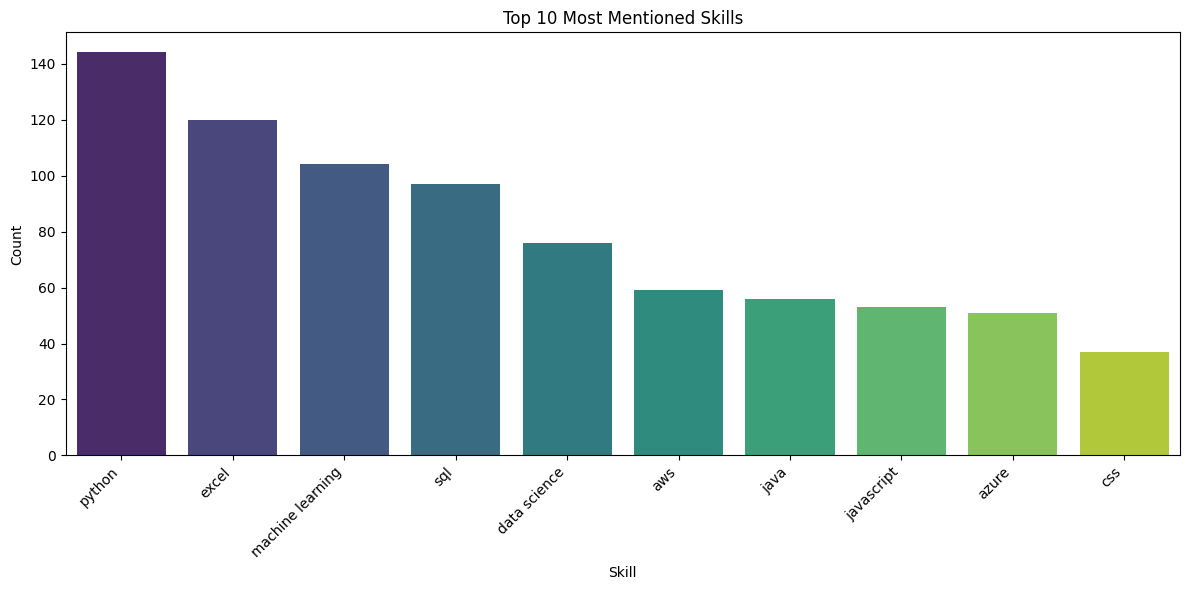

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the skill counts from the CSV file
counts_df = pd.read_csv('skill_counts_from_db.csv')

# Plotting the top 10 skills
plt.figure(figsize=(12, 6))
sns.barplot(x='skill', y='count', data=counts_df.head(10), palette='viridis', hue='skill', legend=False)
plt.title('Top 10 Most Mentioned Skills')
plt.xlabel('Skill')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

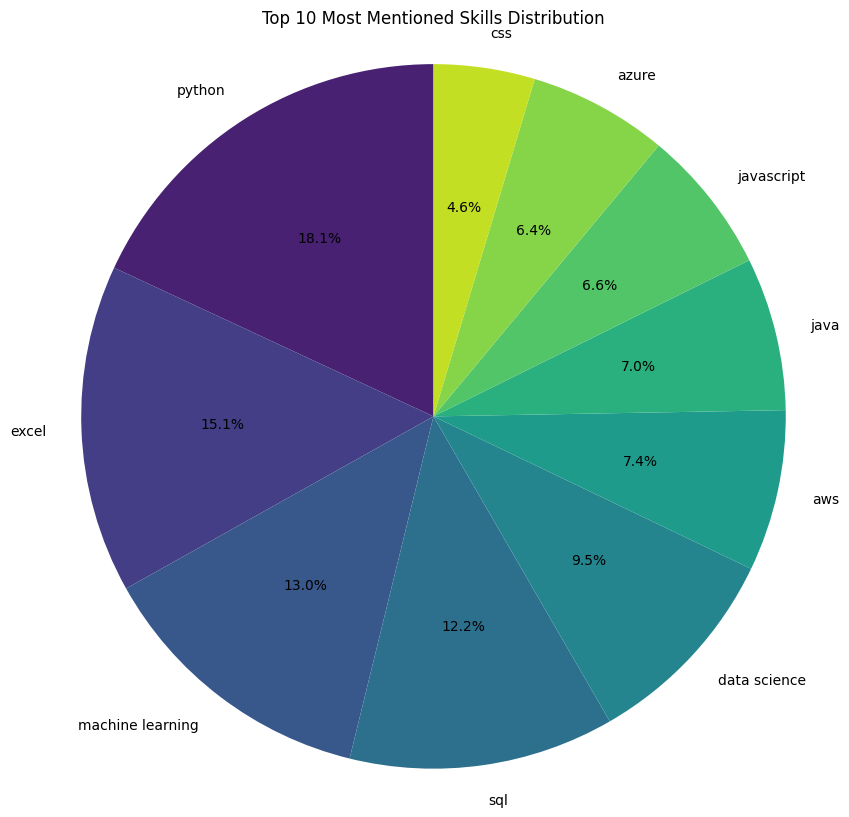

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the top 10 skills from counts_df
top_10_skills = counts_df.head(10)

# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(top_10_skills['count'], labels=top_10_skills['skill'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(top_10_skills)))
plt.title('Top 10 Most Mentioned Skills Distribution')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()